From [Feature Engineering and Analysis on kaggle.com](https://www.kaggle.com/br0kej/feature-engineering-and-analysis/notebook). Adapted to save the split and feature engineered dataset as csv and to only use xgboost.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tld import get_tld
from typing import Tuple, Union, Any

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
df = pd.read_csv('data/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df.shape

(651191, 2)

In [4]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

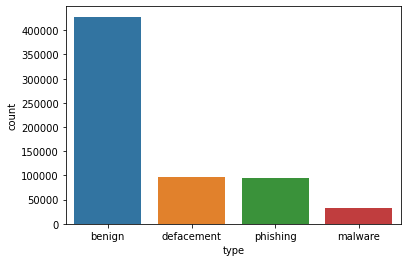

In [5]:
sns.countplot(x = 'type', data = df, order = df['type'].value_counts().index)

In [6]:
def is_url_ip_address(url: str) -> bool:
    return re.search(
        # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        # IPv4 with port
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        # IPv4 in hexadecimal
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'
        # Ipv6
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url) is not None
        

In [7]:
df['is_ip'] = df['url'].apply(lambda i: is_url_ip_address(i))


In [8]:
df['is_ip'].value_counts()

False    638703
True      12488
Name: is_ip, dtype: int64

In [9]:
def process_tld(url: str, fix_protos: bool = False) -> Tuple[str, str, str, str]:
    """
    Takes a URL string and uses the tld library to extract subdomain, domain, top
    level domain and full length domain
    """
    res = get_tld(url, as_object=True, fail_silently=False,
                  fix_protocol=fix_protos)

    subdomain = res.subdomain
    domain = res.domain
    tld = res.tld
    fld = res.fld

    return subdomain, domain, tld, fld


def process_url_with_tld(row: pd.Series) -> Tuple[str, str, str, str]:
    """
    Takes in a dataframe row, checks to see if rows `is_ip` column is
    False. If it is false, continues to process the URL and extract the 
    features, otherwise sets four features to None before returning.

    This processing is wrapped in a try/except block to enable debugging
    and it prints out the inputs that caused a failure as well as a 
    failure counter.
    """
    try:
        if not row['is_ip']:
            if str(row['url']).startswith('http:'):
                return process_tld(row['url'])
            else:
                return process_tld(row['url'], fix_protos=True)
        else:
            subdomain = None
            domain = None
            tld = None
            fld = None
            return subdomain, domain, tld, fld
    except:
        idx = row.name
        url = row['url']
        type = row['type']
        print(f'Failed - {idx}: {url} is a {type} example')
        return None, None, None, None


In [10]:
df[['subdomain', 'domain', 'tld', 'fld']] = df.apply(lambda x: process_url_with_tld(x), axis=1, result_type="expand")

Failed - 555301: www.udc.an/wp-includes/js/tinymce/themes/advanced/img/link.htm is a benign example
Failed - 555675: www.udc.an/wp-includes/js/tinymce/themes/advanced/js/frm.htm is a benign example
Failed - 555800: 772050312/www1.royalbank.com/cgi-bin/rbaccess/rbunxcgi/ is a benign example
Failed - 567197: bin/webscr?cmd=_login- is a benign example
Failed - 573418: wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË
jlÛW¿]ø¾µj¿·ªo!ÒPì ·ÊïH§#'3ø@CÄRõ²çÇÝ®öQBÇÆg`ÈåZéê DîÂm®ÎÝQó*x;9?ÁÒâbùtÖÙ®mÞNP¯°^MQáSò°i°vþ[«³»]¹
(-§;¬ÔAèUèé\¨øíÌdB\[q½=ÿVuÃ»râæHäô/µ}»7!2=´ÂÏ4¿ª¡j91] is a phishing example
Failed - 573419: 'www.institutocgr.coo/web/media/syqvem/dk-óij!R\gr0âÕ5dfe<á<cmg&¤Gh!C<ò¡B-¨¨¼ ¬é'?l pýl ÖÒ%ÓaéþùkzHü]z?¹¯úT£bùÙî¬æÌì*UA×$Ë]õ³¯=Íÿ×ùÁÌý¡(~¶Ar¤÷G\$ðQñº¤KÎåcãÇ +¿Èôäþ(¹÷ sóQ¦NvO4zcÍÐGEõÂÚÃß=.¹ÏßZH{2-®tò¾VX©½½qx¼NÚPmødXæ&Ý»AnÂéa¶A¹®cÐBìß)aÚý^¨'JLî^ ¶ M¹´xxÃu4À@xýe^bÓ¡¹´ÞO7 is a phishing exampl

In [11]:
df[['subdomain', 'domain', 'tld', 'fld']].value_counts()


subdomain  domain                  tld     fld                          
en         wikipedia               org     wikipedia.org                    13206
           youtube                 com     youtube.com                       8617
           facebook                com     facebook.com                      7735
           amazon                  com     amazon.com                        4618
           9779                    info    9779.info                         3984
                                                                            ...  
           montenews               com     montenews.com                        1
           montepaschisiena-login  com     montepaschisiena-login.com           1
                                   online  montepaschisiena-login.online        1
           monteregie-travelguide  com     monteregie-travelguide.com           1
zzz        zggg                    com     zggg.com                             1
Length: 191417, dtype: in

In [12]:
df[['subdomain', 'domain', 'tld', 'fld']].isna().sum(), df['is_ip'].value_counts()


(subdomain    12578
 domain       12578
 tld          12578
 fld          12578
 dtype: int64,
 False    638703
 True      12488
 Name: is_ip, dtype: int64)

In [13]:
df[['subdomain', 'domain', 'tld', 'fld']].isna().sum()[0] - \
    df['is_ip'].value_counts()[1]


90

In [14]:
df.head()

,url,type,is_ip,subdomain,domain,tld,fld
0,br-icloud.com.br,phishing,False,,br-icloud,com.br,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,False,,mp3raid,com,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,False,,bopsecrets,org,bopsecrets.org
3,http://www.garage-pirenne.be/index.php?option=...,defacement,False,www,garage-pirenne,be,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,False,,adventure-nicaragua,net,adventure-nicaragua.net


In [15]:
def get_url_path(url: str) -> Union[str, None]:
    """
    Get's the path from a URL

    For example:

    If the URL was "www.google.co.uk/my/great/path"

    The path returned would be "my/great/path"
    """
    try:
        res = get_tld(url, as_object=True,
                      fail_silently=False, fix_protocol=True)
        if res.parsed_url.query:
            joined = res.parsed_url.path + res.parsed_url.query
            return joined
        else:
            return res.parsed_url.path
    except:
        return None


def alpha_count(url: str) -> int:
    """
    Counts the number of alpha characters in a URL
    """
    alpha = 0
    for i in url:
        if i.isalpha():
            alpha += 1
    return alpha


def digit_count(url: str) -> int:
    """
    Counts the number of digit characters in a URL
    """
    digits = 0
    for i in url:
        if i.isnumeric():
            digits += 1
    return digits


def count_dir_in_url_path(url_path: Union[str, None]) -> int:
    """
    Counts number of / in url path to count number of
    sub directories
    """
    if url_path:
        n_dirs = url_path.count('/')
        return n_dirs
    else:
        return 0


def get_first_dir_len(url_path: Union[str, None]) -> int:
    """
    Counts the length of the first directory within
    the URL provided
    """
    if url_path:
        if len(url_path.split('/')) > 1:
            first_dir_len = len(url_path.split('/')[1])
            return first_dir_len
    else:
        return 0


def contains_shortening_service(url: str) -> int:
    """
    Checks to see whether URL contains a shortening service
    """
    return re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                     'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                     'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                     'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                     'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                     'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                     'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                     'tr\.im|link\.zip\.net',
                     url) is not None


In [16]:
# General Features
df['url_path'] = df['url'].apply(lambda x: get_url_path(x))
df['contains_shortener'] = df['url'].apply(
    lambda x: contains_shortening_service(x))

# URL component length
df['url_len'] = df['url'].apply(lambda x: len(str(x)))
df['subdomain_len'] = df['subdomain'].apply(lambda x: len(str(x)))
df['tld_len'] = df['tld'].apply(lambda x: len(str(x)))
df['fld_len'] = df['fld'].apply(lambda x: len(str(x)))
df['url_path_len'] = df['url_path'].apply(lambda x: len(str(x)))

# Simple count features
df['url_alphas'] = df['url'].apply(lambda i: alpha_count(i))
df['url_digits'] = df['url'].apply(lambda i: digit_count(i))
df['url_puncs'] = (df['url_len'] - (df['url_alphas'] + df['url_digits']))
df['count.'] = df['url'].apply(lambda x: x.count('.'))
df['count@'] = df['url'].apply(lambda x: x.count('@'))
df['count-'] = df['url'].apply(lambda x: x.count('-'))
df['count%'] = df['url'].apply(lambda x: x.count('%'))
df['count?'] = df['url'].apply(lambda x: x.count('?'))
df['count='] = df['url'].apply(lambda x: x.count('='))
df['count_dirs'] = df['url_path'].apply(lambda x: count_dir_in_url_path(x))
df['first_dir_len'] = df['url_path'].apply(lambda x: get_first_dir_len(x))

# Binary Label
df['binary_label'] = df['type'].apply(lambda x: 0 if x == 'benign' else 1)

# Binned Features
groups = ['Short', 'Medium', 'Long', 'Very Long']
# URL Lengths in 4 bins
df['url_len_q'] = pd.qcut(df['url_len'], q=4, labels=groups)
# FLD Lengths in 4 bins
df['fld_len_q'] = pd.qcut(df['fld_len'], q=4, labels=groups)

# Percentage Features
df['pc_alphas'] = df['url_alphas'] / df['url_len']
df['pc_digits'] = df['url_digits'] / df['url_len']
df['pc_puncs'] = df['url_puncs'] / df['url_len']


In [17]:
df[["url_len_q", "fld_len_q"]] = OrdinalEncoder().fit_transform(
    df[["url_len_q", "fld_len_q"]])


In [18]:
df.head()

,url,type,is_ip,subdomain,domain,tld,fld,url_path,contains_shortener,url_len,...,count?,count=,count_dirs,first_dir_len,binary_label,url_len_q,fld_len_q,pc_alphas,pc_digits,pc_puncs
0,br-icloud.com.br,phishing,False,,br-icloud,com.br,br-icloud.com.br,,False,16,...,0,0,0,0.0,1,2.0,0.0,0.812500,0.000000,0.187500
1,mp3raid.com/music/krizz_kaliko.html,benign,False,,mp3raid,com,mp3raid.com,/music/krizz_kaliko.html,False,35,...,0,0,2,5.0,0,1.0,1.0,0.828571,0.028571,0.142857
2,bopsecrets.org/rexroth/cr/1.htm,benign,False,,bopsecrets,org,bopsecrets.org,/rexroth/cr/1.htm,False,31,...,0,0,3,7.0,0,2.0,0.0,0.806452,0.032258,0.161290
3,http://www.garage-pirenne.be/index.php?option=...,defacement,False,www,garage-pirenne,be,garage-pirenne.be,/index.phpoption=com_content&view=article&id=7...,False,88,...,1,4,1,58.0,1,3.0,0.0,0.715909,0.079545,0.204545
4,http://adventure-nicaragua.net/index.php?optio...,defacement,False,,adventure-nicaragua,net,adventure-nicaragua.net,/index.phpoption=com_mailto&tmpl=component&lin...,False,235,...,1,3,1,203.0,1,3.0,3.0,0.846809,0.093617,0.059574


In [19]:
df.describe()

,url_len,subdomain_len,tld_len,fld_len,url_path_len,url_alphas,url_digits,url_puncs,count.,count@,...,count?,count=,count_dirs,first_dir_len,binary_label,url_len_q,fld_len_q,pc_alphas,pc_digits,pc_puncs
count,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,...,651191.000000,651191.000000,651191.000000,651177.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000
mean,60.156831,2.983595,3.208535,13.881697,40.310420,45.247104,5.527409,9.382318,2.195453,0.002219,...,0.223782,0.603863,2.345866,15.029895,0.342585,1.510136,1.461534,0.774518,0.072664,0.152818
std,44.753902,10.064079,1.381402,5.381504,41.526631,31.624502,11.700814,7.962226,1.490732,0.054183,...,0.441220,1.516960,1.674043,26.832904,0.474574,1.115199,1.062725,0.120364,0.101706,0.046464
min,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,3.000000,10.000000,15.000000,25.000000,0.000000,4.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,4.000000,0.000000,1.000000,1.000000,0.732824,0.000000,0.125000
50%,47.000000,0.000000,3.000000,13.000000,29.000000,37.000000,2.000000,7.000000,2.000000,0.000000,...,0.000000,0.000000,2.000000,7.000000,0.000000,2.000000,1.000000,0.800000,0.032258,0.148936
75%,77.000000,3.000000,3.000000,17.000000,56.000000,58.000000,7.000000,12.000000,3.000000,0.000000,...,0.000000,0.000000,3.000000,13.000000,1.000000,2.000000,2.000000,0.857143,0.107143,0.178082
max,2175.000000,230.000000,41.000000,76.000000,2156.000000,2141.000000,1204.000000,372.000000,42.000000,10.000000,...,20.000000,51.000000,39.000000,1674.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Full Length Domain Length')

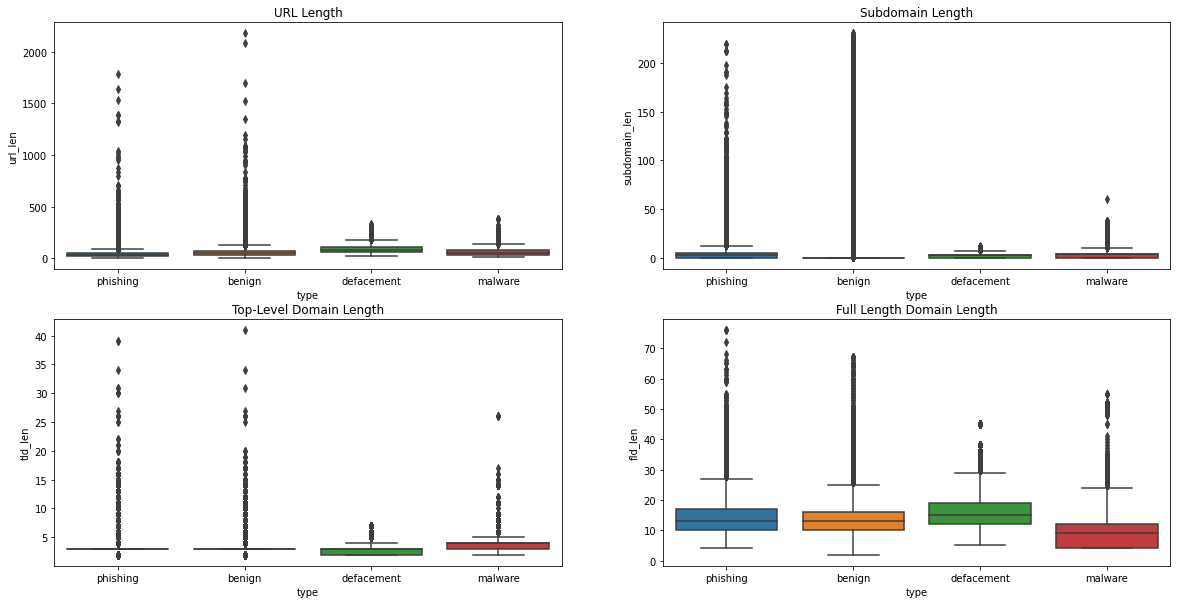

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=False)
sns.boxplot(ax=axes[0, 0], x='type', y='url_len', data=df)
axes[0, 0].set_title('URL Length')
sns.boxplot(ax=axes[0, 1], x='type', y='subdomain_len', data=df)
axes[0, 1].set_title('Subdomain Length')
sns.boxplot(ax=axes[1, 0], x='type', y='tld_len', data=df)
axes[1, 0].set_title('Top-Level Domain Length')
sns.boxplot(ax=axes[1, 1], x='type', y='fld_len', data=df)
axes[1, 1].set_title('Full Length Domain Length')


Text(0.5, 1.0, 'Ratio of Digits to URL')

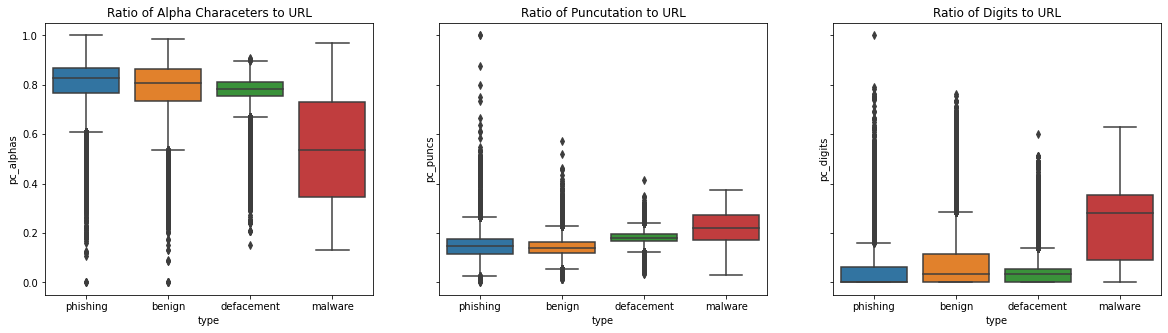

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
sns.boxplot(ax=axes[0], x='type', y='pc_alphas', data=df)
axes[0].set_title('Ratio of Alpha Characeters to URL')
sns.boxplot(ax=axes[1], x='type', y='pc_puncs', data=df)
axes[1].set_title('Ratio of Puncutation to URL')
sns.boxplot(ax=axes[2], x='type', y='pc_digits', data=df)
axes[2].set_title('Ratio of Digits to URL')


Text(0.5, 1.0, 'Ratio of Digits to URL')

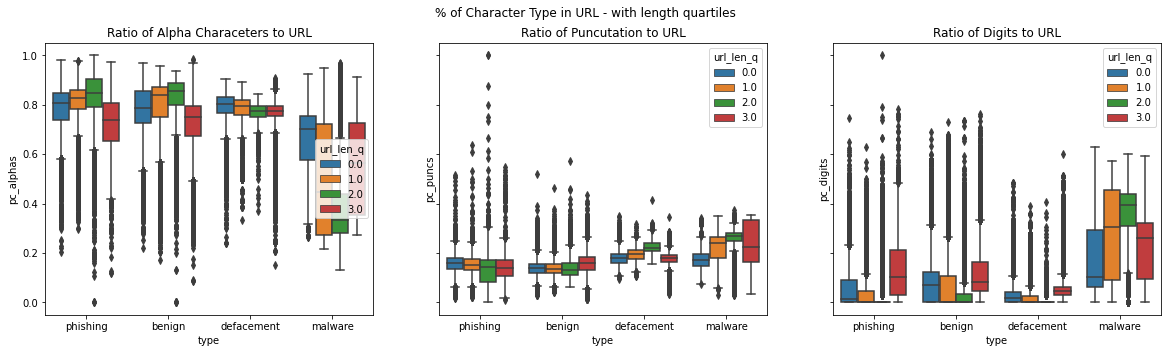

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('% of Character Type in URL - with length quartiles')
sns.boxplot(ax=axes[0], x='type', y='pc_alphas', hue='url_len_q', data=df)
axes[0].set_title('Ratio of Alpha Characeters to URL')
sns.boxplot(ax=axes[1], x='type', y='pc_puncs', hue='url_len_q', data=df)
axes[1].set_title('Ratio of Puncutation to URL')
sns.boxplot(ax=axes[2], x='type', y='pc_digits', hue='url_len_q', data=df)
axes[2].set_title('Ratio of Digits to URL')


<AxesSubplot:xlabel='pc_digits', ylabel='Density'>

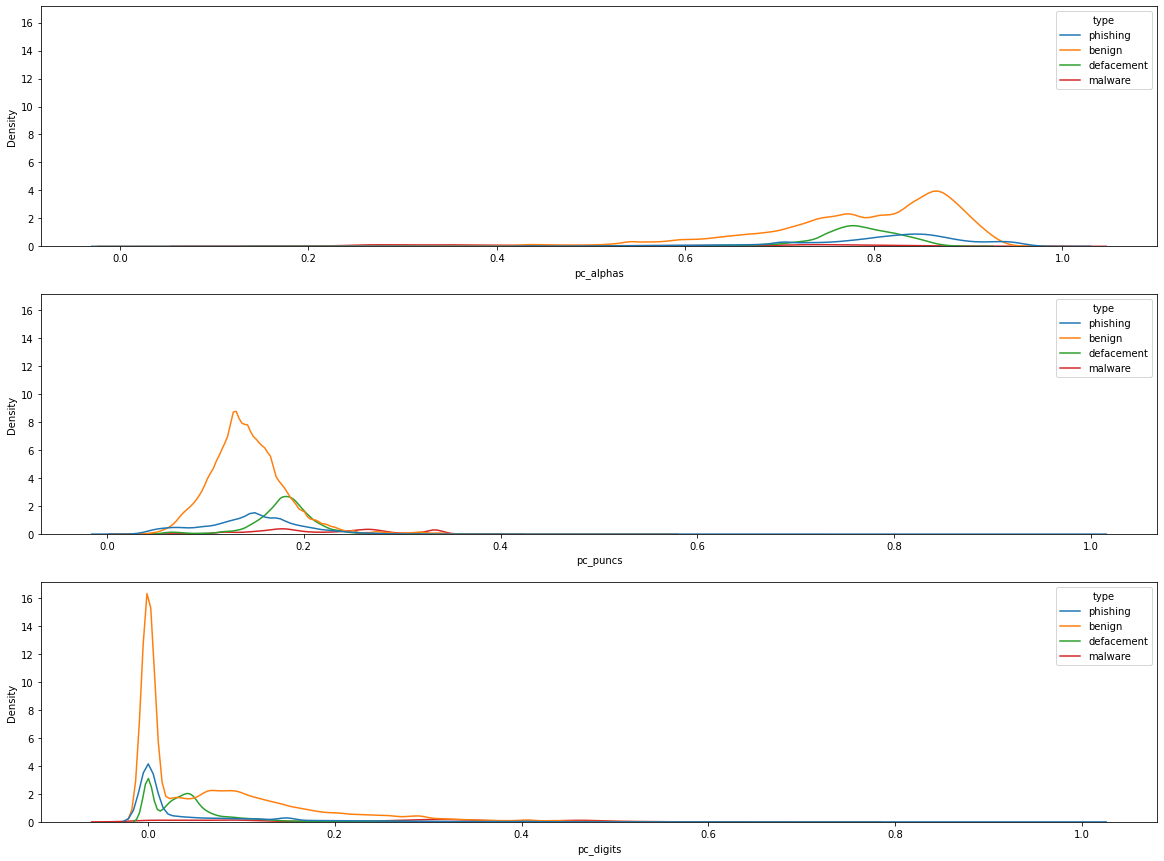

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharey=True)
sns.kdeplot(ax=axes[0], data=df, x="pc_alphas", hue='type')
sns.kdeplot(ax=axes[1], data=df, x="pc_puncs", hue='type')
sns.kdeplot(ax=axes[2], data=df, x="pc_digits", hue='type')

In [24]:
X = df[['is_ip', 'url_len', 'subdomain_len', 'tld_len', 'fld_len', 'url_path_len',
       'url_alphas', 'url_digits', 'url_puncs', 'count.', 'count@', 'count-',
        'count%', 'count?', 'count=',
        'pc_alphas', 'pc_digits', 'pc_puncs', 'count_dirs',
        'contains_shortener', 'first_dir_len',
        'url_len_q', 'fld_len_q']]

y = df['binary_label']


In [25]:
X.isna().sum()

is_ip                  0
url_len                0
subdomain_len          0
tld_len                0
fld_len                0
url_path_len           0
url_alphas             0
url_digits             0
url_puncs              0
count.                 0
count@                 0
count-                 0
count%                 0
count?                 0
count=                 0
pc_alphas              0
pc_digits              0
pc_puncs               0
count_dirs             0
contains_shortener     0
first_dir_len         14
url_len_q              0
fld_len_q              0
dtype: int64

In [26]:
X[X.isnull().any(axis=1)]

,is_ip,url_len,subdomain_len,tld_len,fld_len,url_path_len,url_alphas,url_digits,url_puncs,count.,...,count?,count=,pc_alphas,pc_digits,pc_puncs,count_dirs,contains_shortener,first_dir_len,url_len_q,fld_len_q
521059,False,28,0,4,16,3,21,1,6,1,...,1,1,0.750000,0.035714,0.214286,0,False,NaN,2.0,0.0
521392,False,29,4,3,11,4,16,6,7,2,...,1,1,0.551724,0.206897,0.241379,0,False,NaN,2.0,1.0
526660,False,58,19,2,12,17,49,0,9,2,...,1,0,0.844828,0.000000,0.155172,0,False,NaN,0.0,1.0
528710,False,51,0,2,11,32,42,0,9,2,...,1,1,0.823529,0.000000,0.176471,0,False,NaN,0.0,1.0
531652,False,69,0,12,30,30,56,4,9,2,...,1,3,0.811594,0.057971,0.130435,0,True,NaN,0.0,3.0
531831,False,110,15,3,17,68,89,13,8,2,...,1,1,0.809091,0.118182,0.072727,0,False,NaN,3.0,0.0
556813,False,66,5,2,7,52,46,9,11,9,...,2,0,0.696970,0.136364,0.166667,0,False,NaN,0.0,2.0
559052,False,23,3,2,10,8,17,3,3,2,...,1,0,0.739130,0.130435,0.130435,0,True,NaN,2.0,2.0
559662,False,32,8,3,14,8,24,5,3,2,...,1,0,0.750000,0.156250,0.093750,0,False,NaN,2.0,0.0
566738,False,69,3,3,18,46,54,6,9,3,...,1,3,0.782609,0.086957,0.130435,0,False,NaN,0.0,3.0


In [27]:
df[df['first_dir_len'].isnull()]

,url,type,is_ip,subdomain,domain,tld,fld,url_path,contains_shortener,url_len,...,count?,count=,count_dirs,first_dir_len,binary_label,url_len_q,fld_len_q,pc_alphas,pc_digits,pc_puncs
521059,https://santantotta.info?a=1,phishing,False,,santantotta,info,santantotta.info,a=1,False,28,...,1,1,0,NaN,1,2.0,0.0,0.750000,0.035714,0.214286
521392,https://myo2.bill231.com?o2=2,phishing,False,myo2,bill231,com,bill231.com,o2=2,False,29,...,1,1,0,NaN,1,2.0,1.0,0.551724,0.206897,0.241379
526660,https://secure-account-info.openvcsme.cf?Faceb...,phishing,False,secure-account-info,openvcsme,cf,openvcsme.cf,Facebook-Security,False,58,...,1,0,0,NaN,1,0.0,1.0,0.844828,0.000000,0.155172
528710,http://shtory-g.ru?email=ggradnigo@prepaidlega...,phishing,False,,shtory-g,ru,shtory-g.ru,email=ggradnigo@prepaidlegal.com,False,51,...,1,1,0,NaN,1,0.0,1.0,0.823529,0.000000,0.176471
531652,https://serverinfo1policy.blogspot.com?e=Y2hpb...,phishing,False,,serverinfo1policy,blogspot.com,serverinfo1policy.blogspot.com,e=Y2hpbGxlcnNAdGpzbm93LmNvbQ==,True,69,...,1,3,0,NaN,1,0.0,3.0,0.811594,0.057971,0.130435
531831,https://magazine-luiza9.xtechcommerce.com?fbcl...,phishing,False,magazine-luiza9,xtechcommerce,com,xtechcommerce.com,fbclid=IwAR2fF83Nezc9E971kEokkCMJgjk1cMmmE1OGp...,False,110,...,1,1,0,NaN,1,3.0,0.0,0.809091,0.118182,0.072727
556813,ebasy.xgsm.pl?eBay.com.wbdllsc.login.submit.di...,benign,False,ebasy,xgsm,pl,xgsm.pl,eBay.com.wbdllsc.login.submit.dispatch.3135648...,False,66,...,2,0,0,NaN,0,0.0,2.0,0.696970,0.136364,0.166667
559052,www.tinyurl.pl?rY2kq08Z,benign,False,www,tinyurl,pl,tinyurl.pl,rY2kq08Z,True,23,...,1,0,0,NaN,0,2.0,2.0,0.739130,0.130435,0.130435
559662,c713cf13.whackyvidz.com?wefergeg,benign,False,c713cf13,whackyvidz,com,whackyvidz.com,wefergeg,False,32,...,1,0,0,NaN,0,2.0,0.0,0.750000,0.156250,0.093750
566738,www.rederemunerada.com?user=12689&amp=3Bemailc...,benign,False,www,rederemunerada,com,rederemunerada.com,user=12689&amp=3Bemailconv=igorrgt@hotmail.com,False,69,...,1,3,0,NaN,0,0.0,3.0,0.782609,0.086957,0.130435


In [28]:
X['first_dir_len'].value_counts()

0.0      85082
4.0      77601
6.0      46397
5.0      41371
9.0      40123
         ...  
750.0        1
431.0        1
879.0        1
283.0        1
329.0        1
Name: first_dir_len, Length: 364, dtype: int64

In [29]:
X = X.fillna(0)

In [30]:
X.isna().sum()

is_ip                 0
url_len               0
subdomain_len         0
tld_len               0
fld_len               0
url_path_len          0
url_alphas            0
url_digits            0
url_puncs             0
count.                0
count@                0
count-                0
count%                0
count?                0
count=                0
pc_alphas             0
pc_digits             0
pc_puncs              0
count_dirs            0
contains_shortener    0
first_dir_len         0
url_len_q             0
fld_len_q             0
dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=5)


In [32]:
def make_binary(X):
    df = X
    df['is_ip'] = df['is_ip'] \
        .apply(lambda x: 1 if x else 0)
    df['contains_shortener'] = df['contains_shortener'] \
        .apply(lambda x: 1 if x else 0)
    return df


make_binary(X_train).to_csv(
    'data/malicious_phish_X_train.csv', index=False)
make_binary(X_test).to_csv('data/malicious_phish_X_test.csv', index=False)

y_train.to_csv('data/malicious_phish_y_train.csv', index=False)
y_test.to_csv('data/malicious_phish_y_test.csv', index=False)


In [33]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, use_label_encoder=False)
model.fit(X_train, y_train)

print(model)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)


[11:19:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
              precision    recall  f1-score   support

           0   

<AxesSubplot:>

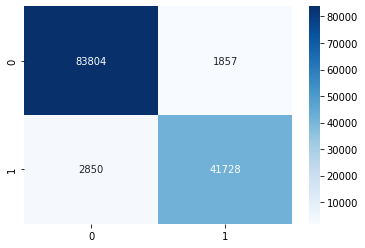

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='g', cmap='Blues')


In [35]:
xgb_features = model.feature_importances_.tolist()

In [36]:
cols = X.columns
feature_importances = pd.DataFrame({'features': cols, 'xgb': xgb_features})
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(
    by='mean_importance', ascending=False)


/tmp/ipykernel_2682/993058951.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feature_importances['mean_importance'] = feature_importances.mean(axis=1)


In [37]:
feature_importances

,features,xgb,mean_importance
2,subdomain_len,0.216596,0.216596
18,count_dirs,0.124940,0.124940
17,pc_puncs,0.074440,0.074440
8,url_puncs,0.054283,0.054283
12,count%,0.049074,0.049074
20,first_dir_len,0.044592,0.044592
5,url_path_len,0.044538,0.044538
14,count=,0.043469,0.043469
11,count-,0.040244,0.040244
3,tld_len,0.036442,0.036442


<AxesSubplot:xlabel='mean_importance', ylabel='features'>

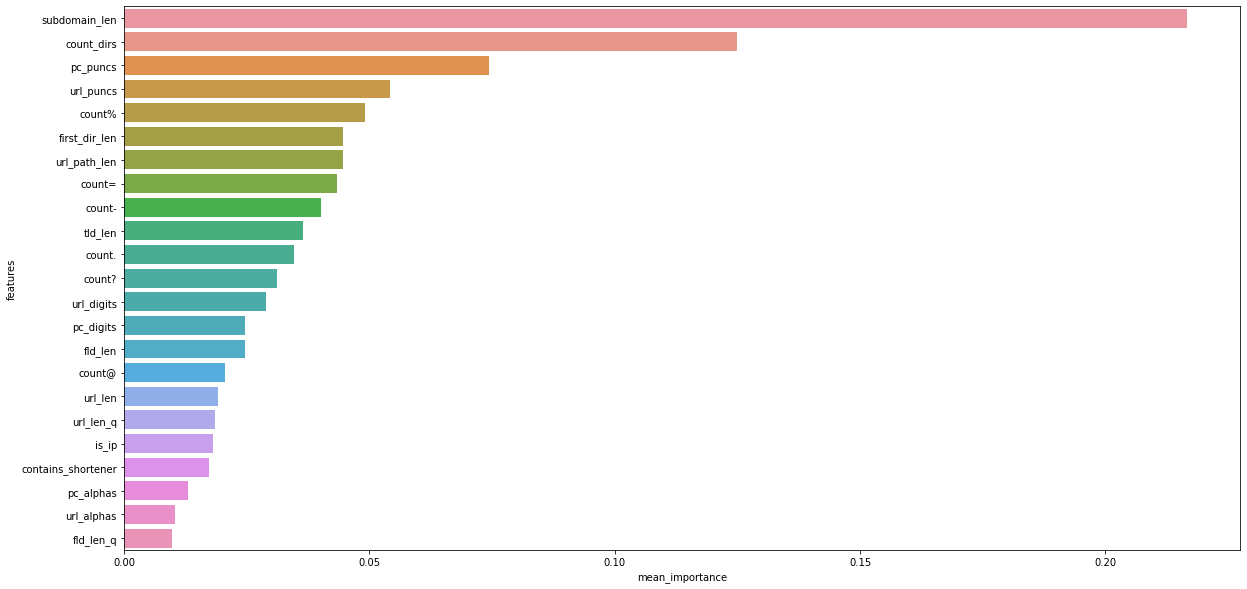

In [38]:
fig, axes = plt.subplots(1, figsize=(20, 10))
sns.barplot(data=feature_importances, x="mean_importance", y='features', ax=axes)